[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mayo-Radiology-Informatics-Lab/MIDeL/blob/main/chapters/7A.ipynb)

*Authors: Bardia Khosravi, MD; Shahriar Faghani, MD*

# 1. **Introduction**

In the previous chapter, we worked with MONAI's transformations to open our images and augment them for the training process. This chapter will show how we can build upon what we created in the previous chapter to prepare the data for training. We will also discuss the concept of *fitness*, the importance of test and validation sets, and the best practices of splitting our data. Let's run some of the code that we created in the previous chapter to set up our workspace.

In [5]:
# @title Run this cell to load the code we wrote in the previous chapter. { vertical-output: true, display-mode: "form" }
# @markdown *This might take a few minutes*.
# @markdown
# @markdown After running this cell we have these variables:
# @markdown *   `train_transforms`: MOANI transforms for training set
# @markdown *   `train_list`: The list of all training examples with their path and label


!pip install monai -q --progress-bar off

import os
from typing import List
from monai.transforms import (
    Compose,
    MapTransform,
    LoadImageD,
    AddChannelD,
    ResizeD,
    RandRotateD,
    ToTensorD,
    SelectItemsD,
)
import copy
import gdown
import numpy as np

# Custom MONAI transform to swap the axes of images
class SwapXYD(MapTransform):
    def __init__(
        self, keys: List[str]
    ) -> None:  # initializing the class and getting the transformation key
        super().__init__(keys)

    def __call__(
        self, data
    ):  # the __call__ method is what is the main method that is executed when we use the transform
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = np.swapaxes(
                d[key], 1, 0
            )  # using numpy to swap axis 1 with 0, which are the X and Y axes.
        return d

# Downloading the zip archive containing training images
if not os.path.isdir("chest_xray"):
    gdown.download(
        "https://drive.google.com/uc?export=download&confirm=pbef&id=1L8ox5fIwb_PijLcPEofQyhe3oGiYESO2",
        "chest_xray.zip",
        quiet=True,
    )
    !unzip -q chest_xray.zip
    os.remove("chest_xray.zip")

# Creating a list of all the training files containing their label and path
train_list = []

for label_idx, label in enumerate(["NORMAL", "PNEUMONIA"]):
    for image_path in os.listdir(f"/content/chest_xray/train/{label}"):
        train_list.append(
            {
                "img": f"/content/chest_xray/train/{label}/{image_path}",
                "label_name": label,
                "label_idx": label_idx,
            }
        )


train_transforms = Compose(
    [
        LoadImageD(keys=["img"]),
        SwapXYD(keys=["img"]),
        AddChannelD(keys=["img"]),
        ResizeD(
            keys=["img"],
            spatial_size=(512, 512),
            mode=["bilinear"],
            align_corners=False,
        ),
        RandRotateD(keys=["img"], range_x=0.17, prob=0.8),
        ToTensorD(keys=["img", "label_idx"]),
        SelectItemsD(keys=["img", "label_idx", "label_name"]),
    ]
)

print("Everything is set!")

Everything is set!


Two different concepts are brought up when we feed our data to our deep learning model, *Dataset* and *Dataloader*. The following two sections describe these concepts in order to understand how to use them in our deep learning pipeline.

# 2. **Creating a Dataset**

A Dataset is an iterable, just like a list, in which each item is associated with an index. Unlike a list, you do not get all of the items at once, but instead you must repeatedly call it to get the next item, compared to a list where you might ask for each item by specifying sequential index values, thus providing each item in the list. 

Why would you want to use an iterable rather than a list? The main reason is that it can save memory--a list must be in the memory of the computer whereas an iterable can be loaded one at a time such as from a disk file. If the file is large compared to the system's RAM, the program may cause a system crash.

To create a dataset, we need to create a class, subclassed to torch's `Dataset` module, with three different methods:


1.   `__init__`: Gets a reference to the collection of data, like a dataframe or list, and any required transformations for each item.
2.   `__getitem__`: Receives an index and has the code to convert that index into an output (which is then fed into a deep learning model).
3.   `__len__`: Returns the number of items in the dataset.

Let's create a dataset class for the pneumonia detection task:

In [6]:
from typing import List, Dict
import monai
from torch.utils.data import Dataset  # Importing the dataset class from pytorch


class PneumoniaDataset(Dataset):
    def __init__(
        self, data: List[Dict], transform: monai.transforms.Compose = None
    ) -> None:
        # gets datalist and transformations
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        # gets an index to choose from the datalist, apply transformations on it, and return it
        item = self.data[idx]
        if self.transform is not None:
            item = self.transform(item)

        return item

    def __len__(self):
        # returns the length of dataset
        return len(self.data)

Now we can check if it works as intended:

In [7]:
train_ds = PneumoniaDataset(
    data=train_list, transform=train_transforms
)  # _ds is short for dataset


print("Data List Length:", len(train_list))
print("Dataset Length:", len(train_ds))

Data List Length: 5233
Dataset Length: 5233


Let's take a look at the 105th item of our dataset:
 (remember-- the first item is at index 0 so index 104 would be the 105th item)

In [8]:
train_ds[104]

{'img': tensor([[[110.7399, 114.3899, 114.0359,  ...,  91.6141,  92.0127,  92.4113],
          [110.6542, 113.8685, 114.1040,  ...,  92.5748,  92.5953,  92.6159],
          [110.5685, 113.3470, 114.1721,  ...,  89.8489,  89.2838,  88.7186],
          ...,
          [ 23.1424,  23.1218,  23.1012,  ...,  25.0000,  25.0000,  25.0000],
          [ 23.0000,  23.0000,  23.0000,  ...,  25.0000,  25.0000,  25.0000],
          [ 22.9814,  22.8598,  22.7382,  ...,  25.0000,  25.0000,  25.0000]]]),
 'label_idx': tensor(0),
 'label_name': 'NORMAL'}

As you might remember, this is exactly the same as the format that our `train_transform` produced. We can visualize a sample to ensure our augmentations work just as we intended.

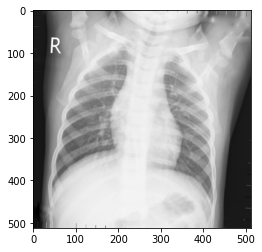

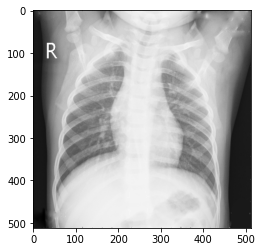

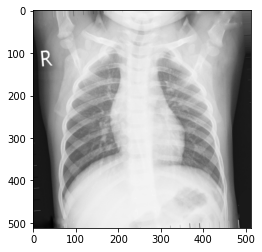

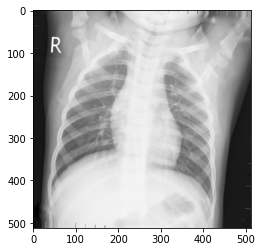

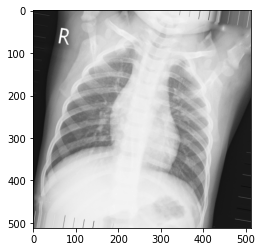

In [9]:
import matplotlib.pyplot as plt

for i in range(5):
    img_array = train_ds[104]["img"]
    plt.imshow(img_array[0], cmap="gray")
    plt.show()

Do we have to write the same code block to create Datasets for each time we try to train a model? No!
MONAI provides a `Dataset` class that is exactly the equivalent of what we wrote. We provided the code to help you understand what is happening, and in case you want to slightly alter the behavior so you can see how that would be done.

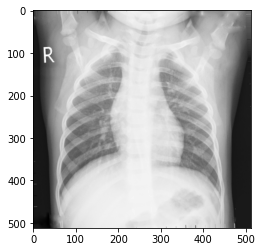

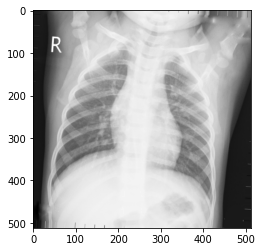

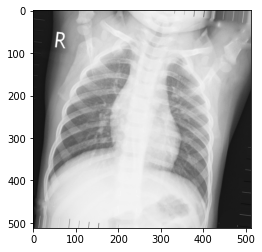

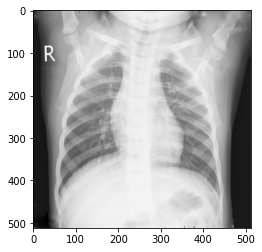

In [10]:
from monai.data import Dataset

train_ds = Dataset(data=train_list, transform=train_transforms)

for i in range(1, 5):
    img_array = train_ds[104]["img"]
    plt.imshow(img_array[0], cmap="gray")
    plt.show()

Now that our dataset is ready, we can make a dataloader from it.

# 3. **Creating a Dataloader**

To improve the training speed and increase representativeness, deep learning models see several samples at once, called a *batch* of data. For example, if the *batch size* is set to 8, your data is broken up into several batches, each containing 8 images and their corresponding labels. Using dataloaders is the simplest way to create these batches from your dataset.

For creating a dataloader, the minimum requirement is to set your dataset and your desired batch size:

In [11]:
from torch.utils.data import DataLoader

batch_size = 8
train_dl = DataLoader(
    dataset=train_ds, batch_size=batch_size
)  # _dl is short for dataloader

Let's check to see how many batches we have: 

In [12]:
print("Dataset Length:", len(train_ds))
print("Dataset Length Devided by Batch Size:", len(train_ds) / 8)
print("Number of Batches:", len(train_dl))

Dataset Length: 5233
Dataset Length Devided by Batch Size: 654.125
Number of Batches: 655


Let's look at the first batch:

In [13]:
first_batch = next(iter(train_dl))
first_batch.keys()

dict_keys(['img', 'label_idx', 'label_name'])

We can see that it has the same keys as our dataset. We can check the shape of `img` and `label_idx` keys: 

In [14]:
print("Batch-Image Shape:", first_batch["img"].shape)
print("Batch-Labels Shape:", first_batch["label_idx"].shape)

Batch-Image Shape: torch.Size([8, 1, 512, 512])
Batch-Labels Shape: torch.Size([8])


As you see, we have 8 images, with one channel, and height and width of 512 pixels. We abbreviate this notation as BCHW (Batch, Channel, Height, Width).
We also have 8 labels, one for each sample.
Let's write a code snippet to visualize each sample in this batch.

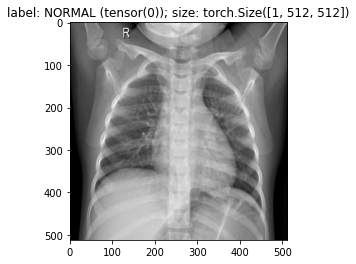

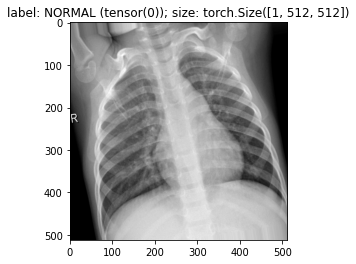

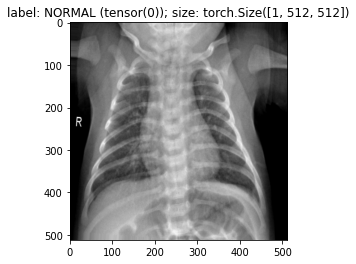

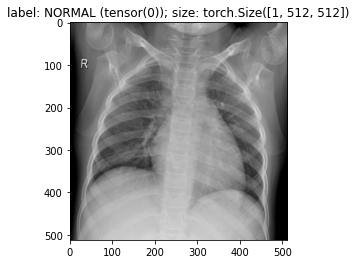

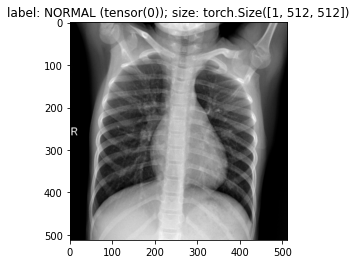

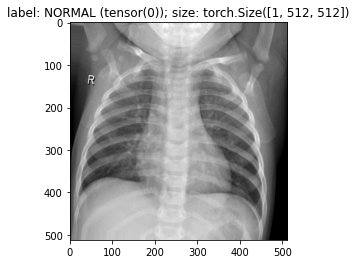

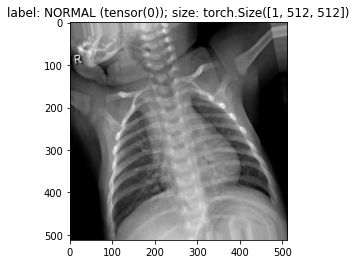

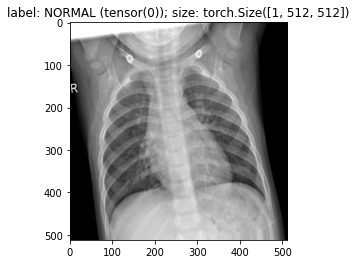

In [15]:
for i in range(batch_size):
    sample_img = first_batch["img"][i]
    sample_label_idx = first_batch["label_idx"][i]
    sample_label_name = first_batch["label_name"][i]

    plt.title(
        f"label: {sample_label_name} ({sample_label_idx}); size: {sample_img.shape}"
    )
    plt.imshow(sample_img[0], cmap="gray")
    # refer to chapter six for the rationale of removing the channel dimension
    plt.show()

As you see, each batch is made up of several different images (from different indices of the dataset).

Dataloaders can accept several parameters besides `dataset` and `batch_size`. Here is a list of some of the more useful parameters and their use cases:

*   `shuffle`: If set to `True`, it will rearrange the order of samples in the dataset. This helps the model see a different combination of samples in each iteration. It is recommended to shuffle the training dataloader, but this is not the case for validation and test dataloaders (see next section).
*   `drop_last`: If set to `True`, it will dismiss the last batch if it does not have the full number of samples (in our case, 8). We have 654 full batches in our pneumonia dataset and one last batch with only one sample in it [`8*654 + 1 = 5233(total samples)`]. By setting this parameter to `True`, the dataloader will drop the last batch and will have a total of 654 batches. It is recommended to have this option set to **False** for training and validation dataloaders, but you can turn it on for training.
*   `num_workers`: This denotes the number of processes that help the dataloader get the data from the dataset. If set to a number greater than `0`, then it will use multiprocessing to prepare your batch, which is genreally faster than having only one worker, but the exact benefit depends on your CPU, RAM, and disk speed. The suggested number of workers can be determined by the number of CPU cores your machine has. You can get it by running this code, but in general it is best to leave this as '0':

In [16]:
print("Number of CPU Cores:", os.cpu_count())

Number of CPU Cores: 2


Now with this additional understanding, we can update our `train_dl` to reflect these changes:

In [17]:
train_dl = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count(),
)

---


> **Exercise 1**: Try to visualize one batch of this shuffled dataloader and compare it with the previous version.


---

# 4. **Data Splitting**

To show the importance of data splitting and how it can help us train our model, we define a hypothetical regression task. We get several input variables in regression tasks and predict a continuous output.

## 4.1. **The Problem of Fitting**

In this task, we want to determine the patient's fasting blood sugar (FBS) as the output of the model using their body mass index (BMI) as input to the model.

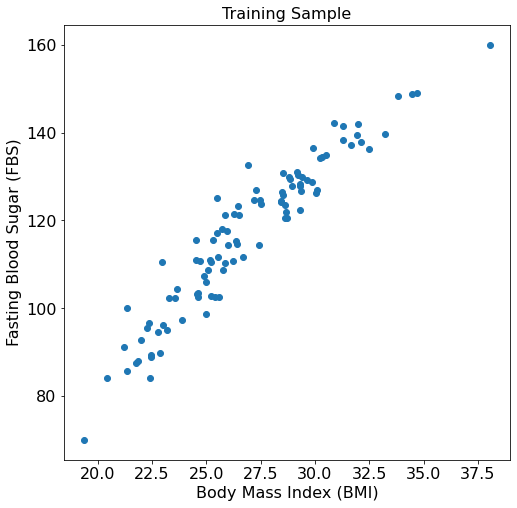

In [18]:
# @title Run this cell to load our training sample. { vertical-output: true, display-mode: "form" }
# @markdown *You can take a peek inside to see how we made this hypothetical dataset*.

FBS = np.random.normal(loc=100, scale=20, size=100) + 20
FBS = np.sort(FBS)

BMI = (
    ((3 * FBS**2 - 100 * FBS) / 3000)
    + 17
    + np.random.normal(loc=0, scale=1, size=100)
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(BMI, FBS)
ax.set_ylabel("Fasting Blood Sugar (FBS)")
ax.set_xlabel("Body Mass Index (BMI)")
ax.set_title("Training Sample")
for item in (
    [ax.title, ax.xaxis.label, ax.yaxis.label]
    + ax.get_xticklabels()
    + ax.get_yticklabels()
):
    item.set_fontsize(16)


plt.show()

Our dataset consists of 100 points, showing a positive correlation between BMI and FBS. Still, it is not a perfectly straight line because of the non-linear relationship between BMI and FBS and the data's inherent noise.

Suppose we train three different models, A, B, and C, by running the cell below:

Model A:   0%|          | 0/100 [00:00<?, ?it/s]

Model B:   0%|          | 0/100 [00:00<?, ?it/s]

Model C:   0%|          | 0/100 [00:00<?, ?it/s]

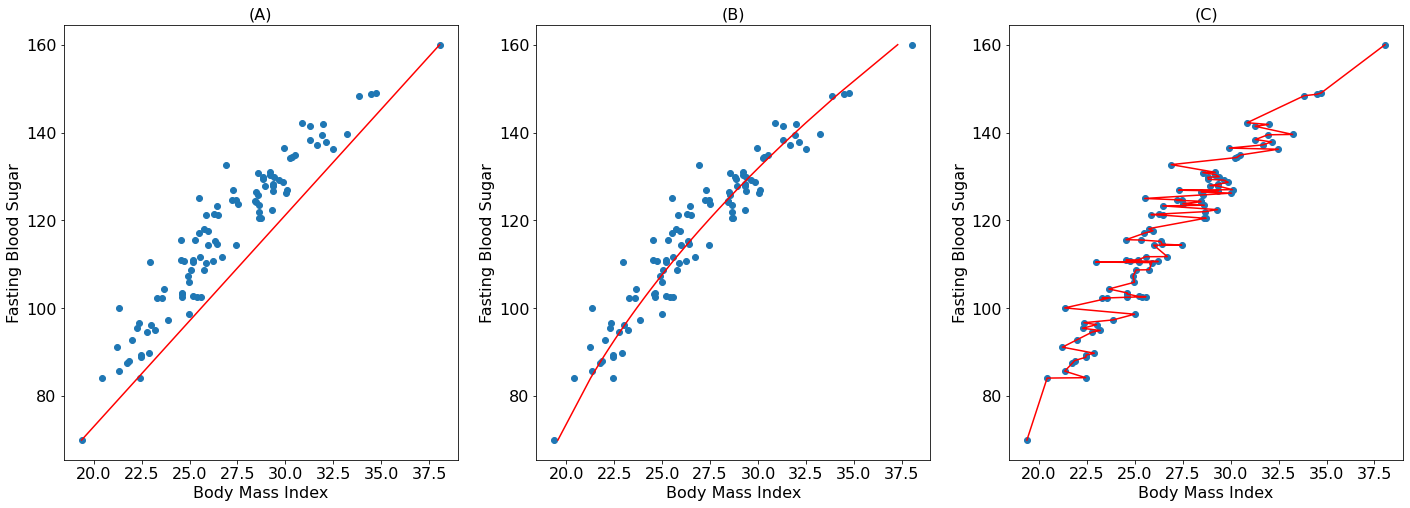

In [19]:
# @title Run this cell to train three hypothetical models. { vertical-output: true, display-mode: "form" }
# @markdown *You can take a peek inside to see how we made this hypothetical dataset*.
from tqdm.auto import tqdm
import time

for model in ["A", "B", "C"]:
    for i in tqdm(range(100), desc=f"Model {model}"):
        time.sleep(0.05)
        pass

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].scatter(BMI, FBS)
ax[0].plot([BMI[0], BMI[-1]], [FBS[0], FBS[-1]], color="red")
ax[0].set_ylabel("Fasting Blood Sugar")
ax[0].set_xlabel("Body Mass Index")
ax[0].set_title("(A)")
ax[1].scatter(BMI, FBS)
ax[1].plot(((3 * FBS**2 - 100 * FBS) / 3000) + 17, FBS, color="red")
ax[1].set_ylabel("Fasting Blood Sugar")
ax[1].set_xlabel("Body Mass Index")
ax[1].set_title("(B)")
ax[2].scatter(BMI, FBS)
ax[2].plot(BMI, FBS, color="red")
ax[2].set_ylabel("Fasting Blood Sugar")
ax[2].set_xlabel("Body Mass Index")
ax[2].set_title("(C)")

for i in range(3):
    for item in (
        [ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label]
        + ax[i].get_xticklabels()
        + ax[i].get_yticklabels()
    ):
        item.set_fontsize(16)

plt.show()

Model A is probably not the desired model since it just captures a linear relationship between the FBS and BMI; technically, we call it an **underfitted** model. On the other hand, model C perfectly matches the data **and** the inherent noise of the data itself. In other words, instead of learning the general relationships between the variables, the model has *memorized* the data, which is not desirable; we technically call this scenario **overfitting**. As you might have guessed, model B has learned the general relationship between the variables without *memorizing* sample-specific detail, which is just **fit** for our problem. Of course, there is judgment in deciding what is the right amount of fit, and that is why knowledge of the domain is critical to getting the desired model.

To put it another way: consider a scenario in which two different students take a mathematics exam. The first student did not learn much during the semester and cannot solve anything more than the most basic exam problems. An underfitted model is like the first student. The second student memorized the answers to all the sample exercises and would perform perfectly if the exam included only questions from the samples, but would do poorly on any novel exam questions because they have not learned how to solve them. An overfitted model is like the second student. A model with a 'good fit' is like a very good student who performs well on both the sample exercises and novel exam questions.

For this reason, we prefer to avoid the term 'perfectly fit' model, as that implies there is only a single way to predict any output from a training set, and that is probably not correct for anything beyond the simplest problem. Instead, we should really only expect that the model will have a 'good fit'.
But the question remains, *how can we know if our model has a good fit?*

## 4.2. **Test and Validation Sets**

To answer this question, we can split our data into two separate sets, one for training the model, and another one for evaluating its performance, called the test set. An underfitted model will not perform well on either the training or the test sets; an overfitted model will perform very well on the training set but performs poorly on the test set; a model that is fit for the task will do well on both the training and test sets. 

However, you might wonder how we can change an already underfitted or overfitted model into a good fitting model? There are several *choices* a developer can make to push their model towards a better fit. These include choices about the architecture of the model, how to penalize the model for its mistakes, and many more decisions that you have to make during the process. These choices are called hyperparameters of your model, and we will discuss them in the following chapters. During training, we typically do tens to hundreds of experiments to *tune* these hyperparameters and find the best performing model that fits our problem. 

Nevertheless, we have to evaluate our model after changing its hyperparameters to see the effect of that change. One approach is to use the test set we put aside and evaluate our model's performance on it after each tuning process. But this leads to a phenomenon called weight *data leakage*. What it means is that the model learning is tuned towards better performance on the test set, which it should not have any idea about during the hyperparameter tuning process. To prevent data leakage from the test set, we will have a different set of data called the validation set to evaluate our model's performance with each change of its hyperparameters. This will lead to information leakage from the validation set, but at least our test set is safe.

To sum up, we can find the best (or at least a good) fit model by properly using the train set and validation set. Once we determine the best hyperparameters of the model, we can report its performance on the test set.

## 4.3. **Splitting Strategies**

There are three general strategies for choosing a validation set that we will cover here. The most straightforward approach is to select a portion of your initial pool and keep it constant in all training instances (*Figure 1a*). 

Another approach is to use **cross-validation**. In this approach, we split our data into `k` splits and train k different models, where each model uses the kth split for validation and the other data for training. In other words, the model tries to learn from `k-1` splits, and one split is used for validation (*Figure 1b*). 

The last approach we will discuss is **nested cross-validation** (also known as double cross-validation). To utilize this technique, first, we do a conventional cross-validation split, and then in each run, we split our `k-1` splits into `m` splits and use these splits to do the cross-validation. So you first train your model on `m-1` splits and then validate the model on the one remaining split within each of the `k` splits and repeat it `k` times (*Figure 1c*). As you might have noticed, this way, the results are from `k*m` runs, which can quickly get out of hand. But if we manage this complexity, then we have a highly reliable measure of our model’s performance.


<br><img src="https://i.ibb.co/fQyp1zm/Fig1.png" alt="Figure 1" style='margin:auto' border="0"><u><b><br />Figure 1.</b>  Different data splitting strategies ([source](https://pubs.rsna.org/doi/10.1148/ryai.210290))</u><br><br>


Regardless of what approach we choose, there are some considerations for splitting medical datasets.

## 4.4. **Cautions on Medical Data Splitting**

Regardless of which strategy we use to select our validation set, we must keep in mind a couple of points to get more generalizable results. 

Whether we use cross-validation or not, the first thing we want to consider is that we desire that our validation set represents the full population. For example, if we have 25% normal cases in our training set, we will likely want this same proportion in our test and validation sets, though there can be times when one will want to 'enrich' the frequency of a certain label in the test set, such as when a given label is quite rare. Selecting cases for the training/validation/testing sets in a way that provides similar distributions is called stratification. Let us have 10 folds with approximately the same number of pneumonia cases:

In [20]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# convert out train_list to pandas dataframe for a more easier interface
train_df = pd.DataFrame(train_list)

# creating a fold column to accomodate the final fold number for each sample
train_df["fold"] = -1

# splitter takes care of the splitting, we just tell it how many splits (folds) we want
splitter = StratifiedKFold(n_splits=10)

# for each split, we get the fold id (0-9 for 10 folds), id of the training and validation samples
# y column is the column we want to stratify between folds
for fold_idx, (train_index, val_index) in enumerate(
    splitter.split(train_df, y=train_df["label_idx"])
):
    # we only save the fold number for the validation sets as the training folds can be calculated based on them
    train_df.loc[val_index, "fold"] = fold_idx

# shuffle the dataframe for visualization purposes only
train_df.sample(frac=1).head(10)

,img,label_name,label_idx,fold
36,/content/chest_xray/train/NORMAL/NORMAL2-IM-09...,NORMAL,0,0
4696,/content/chest_xray/train/PNEUMONIA/person1311...,PNEUMONIA,1,8
5213,/content/chest_xray/train/PNEUMONIA/person470_...,PNEUMONIA,1,9
3068,/content/chest_xray/train/PNEUMONIA/person569_...,PNEUMONIA,1,4
2256,/content/chest_xray/train/PNEUMONIA/person357_...,PNEUMONIA,1,2
3494,/content/chest_xray/train/PNEUMONIA/person515_...,PNEUMONIA,1,5
2000,/content/chest_xray/train/PNEUMONIA/person472_...,PNEUMONIA,1,1
4637,/content/chest_xray/train/PNEUMONIA/person1462...,PNEUMONIA,1,8
2975,/content/chest_xray/train/PNEUMONIA/person548_...,PNEUMONIA,1,4
1691,/content/chest_xray/train/PNEUMONIA/person281_...,PNEUMONIA,1,0


Let's get the number of pneumonia and normal cases in each fold: 

In [21]:
for fold in range(10):
    fold_df = train_df[train_df["fold"] == fold]
    print(f"Fold {fold} stats:")
    print("Normal Cases:", len(fold_df[fold_df["label_idx"] == 0]))
    print("Pneumonia Cases:", len(fold_df[fold_df["label_idx"] == 1]))
    print("---" * 10)

Fold 0 stats:
Normal Cases: 135
Pneumonia Cases: 389
------------------------------
Fold 1 stats:
Normal Cases: 135
Pneumonia Cases: 389
------------------------------
Fold 2 stats:
Normal Cases: 135
Pneumonia Cases: 389
------------------------------
Fold 3 stats:
Normal Cases: 135
Pneumonia Cases: 388
------------------------------
Fold 4 stats:
Normal Cases: 135
Pneumonia Cases: 388
------------------------------
Fold 5 stats:
Normal Cases: 135
Pneumonia Cases: 388
------------------------------
Fold 6 stats:
Normal Cases: 135
Pneumonia Cases: 388
------------------------------
Fold 7 stats:
Normal Cases: 135
Pneumonia Cases: 388
------------------------------
Fold 8 stats:
Normal Cases: 135
Pneumonia Cases: 388
------------------------------
Fold 9 stats:
Normal Cases: 134
Pneumonia Cases: 389
------------------------------


You see that each of our folds has roughly the same number of pneumonia and normal cases.

One more caveat in medical imaging tasks is that each individual has lots of anatomic details, and even if these other details are not related to the task, an AI may still use these as cues to improve performance. This can lead to overfitting by recognizing these unique features for each person and associating them to the disease label, leading to falsely high performance metrics. Moreover, scans from an individual resemble each other quite a lot. So when splitting our data, we have to ensure that we put scans of an individual in the same split (fold), either all in training or all in the validation, otherwise that same individual could have images in both the training and testing set. Ensuring that images for a given individual are within the same split is called *grouping*.

Our current dataset is anonymized and does not contain sensitive information about patients. However, for the sake of demonstration, you can run the following cell to create a dummy column of patient IDs:

In [22]:
# @title Run this cell to create dummy patient IDs. { vertical-output: true, display-mode: "form" }
# @markdown *You can take a peek inside to see how we made this dummy variable*.

train_df["patient_id"] = np.random.randint(100, 600, train_df.shape[0])
train_df.head()

,img,label_name,label_idx,fold,patient_id
0,/content/chest_xray/train/NORMAL/IM-0160-0001....,NORMAL,0,0,544
1,/content/chest_xray/train/NORMAL/NORMAL2-IM-11...,NORMAL,0,0,102
2,/content/chest_xray/train/NORMAL/NORMAL2-IM-03...,NORMAL,0,0,528
3,/content/chest_xray/train/NORMAL/IM-0630-0001....,NORMAL,0,0,112
4,/content/chest_xray/train/NORMAL/IM-0467-0001-...,NORMAL,0,0,414


We can now split our folds in a way that considers both grouping (based on patient IDs) and stratification (based on labels):

In [23]:
from sklearn.model_selection import StratifiedGroupKFold

# resetting the fold column
train_df["fold"] = -1

# we change the splitter to StratifiedGroupKFold
splitter = StratifiedGroupKFold(n_splits=10)

# for each split, we get the fold id (0-9 for 10 folds), id of the training and validation samples
# the groups parameter gets the grouping variable
for fold_idx, (train_index, val_index) in enumerate(
    splitter.split(train_df, y=train_df["label_idx"], groups=train_df["patient_id"])
):
    # we only save the fold number for the validation sets as the training folds can be calculated based on them
    train_df.loc[val_index, "fold"] = fold_idx

# shuffle the dataframe for visualization purposes only
train_df.sample(frac=1).head(10)

,img,label_name,label_idx,fold,patient_id
3977,/content/chest_xray/train/PNEUMONIA/person325_...,PNEUMONIA,1,6,110
1560,/content/chest_xray/train/PNEUMONIA/person441_...,PNEUMONIA,1,9,308
1894,/content/chest_xray/train/PNEUMONIA/person761_...,PNEUMONIA,1,3,529
1941,/content/chest_xray/train/PNEUMONIA/person612_...,PNEUMONIA,1,5,304
2636,/content/chest_xray/train/PNEUMONIA/person921_...,PNEUMONIA,1,5,375
3523,/content/chest_xray/train/PNEUMONIA/person25_b...,PNEUMONIA,1,8,148
1454,/content/chest_xray/train/PNEUMONIA/person859_...,PNEUMONIA,1,0,272
375,/content/chest_xray/train/NORMAL/IM-0629-0001-...,NORMAL,0,5,492
4791,/content/chest_xray/train/PNEUMONIA/person853_...,PNEUMONIA,1,7,317
3601,/content/chest_xray/train/PNEUMONIA/person1168...,PNEUMONIA,1,6,110


Let's check if there is any overlap of patients across folds:

In [24]:
leaked_patients_count = 0
patient_ids = train_df["patient_id"].unique()
for patient_id in patient_ids:
    all_folds = train_df[train_df["patient_id"] == patient_id]["fold"].unique().tolist()
    if len(all_folds) > 1:
        leaked_patients_count += 1

        print("Patient ID:", patient_id)
        print("Folds:", all_folds)
        print("---" * 10)

if leaked_patients_count == 0:
    print("No patient is in more than one fold.")

No patient is in more than one fold.


The `StratifiedGroupKFold` method is one of the best approaches for splitting your dataset into representative folds, while keeping images for a given patient within the same split.

# 5. **Summary and Further Reading**

This chapter reviewed the steps that should be taken to go from a list of data paths to having a dataset and dataloader. We also covered why we need test and validation sets along with the training set. Finally, we reviewed the best practices of splitting our data and some of the considerations specific to medical imaging. Here are some of the resources that we think might be helpful for further reading:

*   [MONAI's dataset documentation](https://docs.monai.io/en/stable/data.html): We encourage you to review the section on `PersistentDataset` from MONAI to get familiarized with *smarter* and faster datasets.

*   [Scikit Learn's cross-validation iterators](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators): This document goes over different types of splitters that are available to you for creating your cross-validation folds.

`TO BE COMPLETED...`

---

##***Feedback***

*Now that you have completed this chapter, we would be very grateful if you spend a few minutes of your time to answer a short survey about this chapter. We highly value your feedback and will do our best to leverage this to improve our educational content and/or strategies.*

[Click here to begin the survey!](https://docs.google.com/forms/d/e/1FAIpQLSddhdaAmeHmrKKRNXCLIQH6_mnIC3KR7XlDIVWGt3FSQhPDhQ/viewform)